<a href="https://colab.research.google.com/github/chardiwall/DPSNN/blob/main/DPSNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Discription
**Title:** DPSNN (A Differentially Private Spiking Neural Network with Temporal Enhanced Polling).

**Objectives:** Implementation of the [paper](https://arxiv.org/pdf/2205.12718.pdf).

**Discription:** The project is set in the context of the growing field of social robotics, which involves the deployment of robots in human-centric environments. These environments can range from healthcare facilities and educational institutions to customer service and domestic settings. The unique aspect of this project lies in its focus on privacy-preserving mechanisms, an increasingly critical concern in today's data-driven world.


[GitHub Link](https://github.com/chardiwall/DPSNN)

---
## Frameworks
SNN framwork: [SNNTorch](https://snntorch.readthedocs.io/en/latest/)

DP framwork: [Opacus](https://github.com/pytorch/opacus)

---
## Datasets

| Static      | Neuromorphic |
--------------|----------------
| [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)      |[N-MNIST](https://www.garrickorchard.com/datasets/n-mnist#h.p_ID_38) |
| [MNIST](https://yann.lecun.com/exdb/mnist/)      | [CIFAR10-DVS](https://figshare.com/articles/dataset/CIFAR10-DVS_New/4724671/2) |
| [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)      |   |

---


# Loading Essential Libraries

In [2]:
# !pip install -q opacus
!pip install -q snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 6.6 MB/s eta 0:00:00


In [ ]:
# Mounting Google Drive as drive
from google.colab import drive
drive.mount('drive')

In [3]:
import os
import sys
import itertools
from copy import copy
from glob import glob
from tqdm import tqdm
from zipfile import ZipFile
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
from torchvision import datasets, transforms


import snntorch as snn
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils, surrogate

# Unzipping and Loading Data

## Neuromorphic Data

In [ ]:
# N-MNIST

# unzipping the data
base_dir_path = '/content/drive/MyDrive/Colab Notebooks/DPSNN/N-MNIST/'
train_zip_name = 'Copy of Train'
test_zip_name = 'Copy of Test'

for zip_file in [train_zip_name, test_zip_name]:
  zip_path = os.path.join(base_dir_path, zip_file+'.zip')

  with ZipFile(zip_path, 'r') as zip_ref:
    # extraction_path = os.path.join(base_dir_path, zip_file)
    # if not (os.path.exists(extraction_path)):
    #   os.mkdir(extraction_path)
    zip_ref.extractall(base_dir_path)


In [ ]:
# CIFAR10-DVS
base_dir_path = '/content/drive/MyDrive/Colab Notebooks/DPSNN/CIFAR10-DVS'
file_name = 'CIFAR10-DVS.zip'

with ZipFile(os.path.join(base_dir_path, file_name), 'r') as zip_ref:
  zip_ref.extractall(base_dir_path)

## Static Data

In [4]:
def fetch_static_data(name = 'mnist', transform = None, batch_size = 64, shuffle = True):
  """
    Fetches static datasets such as MNIST, Fashion MNIST, and CIFAR10.

    Args:
    - name (str): Name of the dataset ('mnist', 'fashion-mnist', 'cifar10').
    - transform (callable, optional): A function/transform to apply to the data.
    - batch_size (int, optional): Number of samples in each batch.
    - shuffle (bool, optional): Set to True to shuffle the data.

    Returns:
    - train_loader (DataLoader): DataLoader for the training set.
    - test_loader (DataLoader): DataLoader for the test set.
    """


  # MNIST
  if name.lower() == 'mnist':
    train = datasets.MNIST(root = '.', train=True, transform=transform, download=True)
    test = datasets.MNIST(root = '.', train=False, transform=transform, download=True)

  # Fashion MNIST
  elif name.lower() == 'fashion-mnist':
    train = datasets.FashionMNIST(root = '.', train=True, transform=transform, download=True)
    test = datasets.FashionMNIST(root = '.', train=False, transform=transform, download=True)

  # CIFAR10
  elif name.lower() == 'cifar-10':
    train = datasets.CIFAR10('.', train = True, transform = transform, download = True)
    test = datasets.CIFAR10('.', train = False, transform = transform, download = True)

  else:
    raise Exception('Error! '+ name +' dataset not found...')

  train_loader = DataLoader(train, batch_size= batch_size, shuffle=shuffle, drop_last = True)
  test_loader = DataLoader(test, batch_size= batch_size, shuffle=shuffle, drop_last = True)

  return train_loader, test_loader

# Building SNN

## Initializing The Network


<details>
<summary> Show Code Block </summary>
```
class SNN(nn.Module):
  def __init__(self):
    super().__init__()

    # First convolutional block
    self.cb_01 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 12, kernel_size = 5),
        nn.GroupNorm(num_groups = 6, num_channels= 12),
        snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),
    )

    # Second convolutional block
    self.cb_02 = nn.Sequential(
        nn.Conv2d(in_channels = 12, out_channels = 64, kernel_size = 5),
        nn.GroupNorm(num_groups = 8, num_channels = 64),
        snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),
    )

    # Average pooling layer
    self.pooling = nn.AvgPool2d(3)

    # Third convolutional block
    self.cb_03 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5),
        nn.GroupNorm(num_groups = 8, num_channels = 128),
        snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),
    )

    # Fully Connected Layer
    self.FC = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 128 * 2 * 2, out_features= 10),
        snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True, output=True)
    )
    
  def forward(self, x):
    # Forward pass through the network
    x = self.cb_01(x)
    x = self.cb_02(x)
    x = self.pooling(x)
    x = self.cb_03(x)
    x = self.FC(x)

    return x
```
</details>

In [5]:
# using gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

### Mnist Architecture

In [6]:
mnist_net = nn.Sequential(
  # First convolution block
  nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 7),
  nn.GroupNorm(num_groups = 8, num_channels= 32),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Pooling
  nn.AvgPool2d(2),

  #Second convolution block
  nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4),
  nn.GroupNorm(num_groups = 8, num_channels = 64),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Pooling
  nn.AvgPool2d(2),

  # Fully connected or output block
  nn.Flatten(),
  nn.Linear(in_features = 64 * 4 * 4, out_features= 10),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True, output=True)
).to(device)

### CIFAR-10

In [8]:
cifar_10 = nn.Sequential(
  # First convolution block
  nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 64),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Second convolution block
  nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 64),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Pooling
  nn.AvgPool2d(5),

  # Third convolution block
  nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 128),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Forth convolution block
  nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 128),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Pooling
  nn.AvgPool2d(5),

  # Fifth convolution block
  nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 128),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Sixth convolution block
  nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 128),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Pooling
  nn.AvgPool2d(5),

  # Seventh convolution block
  nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 256),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # eighth convolution block
  nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 256),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Pooling
  nn.AvgPool2d(4),

  # Fully connected or output block
  nn.Flatten(),
  nn.Linear(in_features = 256 * 4 * 4, out_features= 10),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True, output=True)
).to(device)

### CIFAR-10-DVS

In [9]:
cifar_10_dvs = nn.Sequential(
  # First convolution block
  nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 64),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Second convolution block
  nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 64),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Pooling
  nn.AvgPool2d(4),

  # Third convolution block
  nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 128),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Pooling
  nn.AvgPool2d(4),

  # Forth convolution block
  nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 256),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Fifth convolution block
  nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 256),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Pooling
  nn.AvgPool2d(4),

  # Sixth convolution block
  nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 512),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Pooling
  nn.AvgPool2d(4),

   # Seventh convolution block
  nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 1024),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Fifth convolution block
  nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 1),
  nn.GroupNorm(num_groups = 8, num_channels= 1024),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True),

  # Pooling
  nn.AvgPool2d(4),

  # Fully connected or output block
  nn.Flatten(),
  nn.Linear(in_features = 1024 * 4 * 4, out_features= 10),
  snn.Leaky(beta = 0.5, spike_grad = surrogate.fast_sigmoid(slope = 25), init_hidden = True, output=True)
).to(device)

## Training the Network

In [7]:
# tranformer
transform = transforms.Compose([
  transforms.Resize(size = (28, 28)),
  transforms.Grayscale(),
  transforms.ToTensor(),
  transforms.Normalize((0,), (1,))
])

In [8]:
def plot_training_history(history):
    # Set the style of seaborn for more beautiful plots
    sns.set(style="whitegrid")

    # Set up the matplotlib figure with a certain size
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    # Plot Training and Testing Accuracy
    axes[0].plot(history['Training Accuracy'], label='Training Accuracy')
    axes[0].plot(history['Testing Accuracy'], label='Testing Accuracy')
    axes[0].set_title('Training and Testing Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Plot Training and Testing Loss
    axes[1].plot(history['Training Loss'], label='Training Loss')
    axes[1].plot(history['Testing Loss'], label='Testing Loss')
    axes[1].set_title('Training and Testing Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

In [9]:
def fwrd_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [10]:
def train_network(net = mnist_net, dataset_name = 'mnist', epoches = 1, lr = 1e-5, betas=(0.9, 0.999), transform = transform, batch_size = 128, shuffle = True):
  # storing training and testin history
  history = dict()
  history['Training Accuracy'] = list()
  history['Testing Accuracy'] = list()

  history['Training Loss'] = list()
  history['Testing Loss'] = list()

  # Define loss function and optimizer
  loss = SF.ce_rate_loss()
  optimizer = torch.optim.AdamW(net.parameters(), lr = lr, betas = betas)

  # Fetching dataset
  train_loader, test_loader = fetch_static_data( name = dataset_name, transform = transform, batch_size = batch_size, shuffle = shuffle)

  # Creating Training and evaluation loop
  for epoch in range(epoches):
    # Training model
    net.train()

    # Tracking accuracy and loss of training.
    train_acc, train_loss, train_acc_total = 0, 0, 0

    for X, y in train_loader:
      # sending the data to same device
      X, y = X.to(device), y.to(device)

      # forward pass
      spk_rec, _ = fwrd_pass(net, 10, X)

      # initialize the loss & sum over time
      loss_val = loss(spk_rec, y)

      # Gradient calculation + weight update
      optimizer.zero_grad()
      loss_val.backward()
      optimizer.step()

      # calculating accuracy and loss
      train_acc += SF.accuracy_rate(spk_rec, y) * spk_rec.size(1)
      train_acc_total += spk_rec.size(1)

      train_loss += loss_val.item()


    # Evaluating model
    net.eval

    # Tracking accuracy and loss of training.
    test_acc, test_loss, test_acc_total = 0, 0, 0

    with torch.inference_mode():
      for X, y in test_loader:
        # sending the data to same device
        X, y = X.to(device), y.to(device)

        # forward pass
        spk_rec, _ = fwrd_pass(net, 10, X)

        # initialize the loss & sum over time
        loss_val = loss(spk_rec, y)


        # calculating accuracy and loss
        test_acc += SF.accuracy_rate(spk_rec, y) * spk_rec.size(1)
        test_acc_total += spk_rec.size(1)

        test_loss += loss_val.item()


    history['Training Accuracy'].append(train_acc/train_acc_total)
    history['Testing Accuracy'].append(test_acc/test_acc_total)

    history['Training Loss'].append(train_loss/batch_size)
    history['Testing Loss'].append(test_loss/batch_size)

    print(f'Epoch: {epoch}: Train Accuracy -> {(train_acc/train_acc_total) * 100:.2f}, Test Accuracy -> {(test_acc/test_acc_total) * 100:.2f}, Train Loss -> {(train_loss/batch_size):.2f}, Test Loss -> {(test_loss/batch_size):.2f}')


  return [net, history]

In [11]:
summary(mnist_net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 22, 22]           1,600
         GroupNorm-2           [-1, 32, 22, 22]              64
             Leaky-3           [-1, 32, 22, 22]               0
         AvgPool2d-4           [-1, 32, 11, 11]               0
            Conv2d-5             [-1, 64, 8, 8]          32,832
         GroupNorm-6             [-1, 64, 8, 8]             128
             Leaky-7             [-1, 64, 8, 8]               0
         AvgPool2d-8             [-1, 64, 4, 4]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                   [-1, 10]          10,250
            Leaky-11       [[-1, 10], [-1, 10]]               0
Total params: 44,874
Trainable params: 44,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

100%|██████████| 9912422/9912422 [00:00<00:00, 159549436.43it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 132099993.26it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 105045664.24it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 9631207.67it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch: 0: Train Accuracy -> 16.27, Test Accuracy -> 30.45, Train Loss -> 0.52, Test Loss -> 0.08
Epoch: 1: Train Accuracy -> 44.00, Test Accuracy -> 55.98, Train Loss -> 0.50, Test Loss -> 0.08
Epoch: 2: Train Accuracy -> 65.71, Test Accuracy -> 78.48, Train Loss -> 0.48, Test Loss -> 0.08
Epoch: 3: Train Accuracy -> 79.10, Test Accuracy -> 78.50, Train Loss -> 0.46, Test Loss -> 0.07
Epoch: 4: Train Accuracy -> 75.75, Test Accuracy -> 74.84, Train Loss -> 0.44, Test Loss -> 0.07
Epoch: 5: Train Accuracy -> 75.65, Test Accuracy -> 78.24, Train Loss -> 0.42, Test Loss -> 0.07
Epoch: 6: Train Accuracy -> 81.95, Test Accuracy -> 86.45, Train Loss -> 0.41, Test Loss -> 0.07
Epoch: 7: Train Accuracy -> 87.15, Test Accuracy -> 89.22, Train Loss -> 0.40, Test Loss -> 0.06
Epoch: 8: Train Accuracy -> 89.10, Test Accuracy -> 90.71, Train Loss -> 0.39, Test Loss -> 0.06
Epoch: 9: Train Accuracy -> 90.19, Test Accuracy -> 91.37, Tra

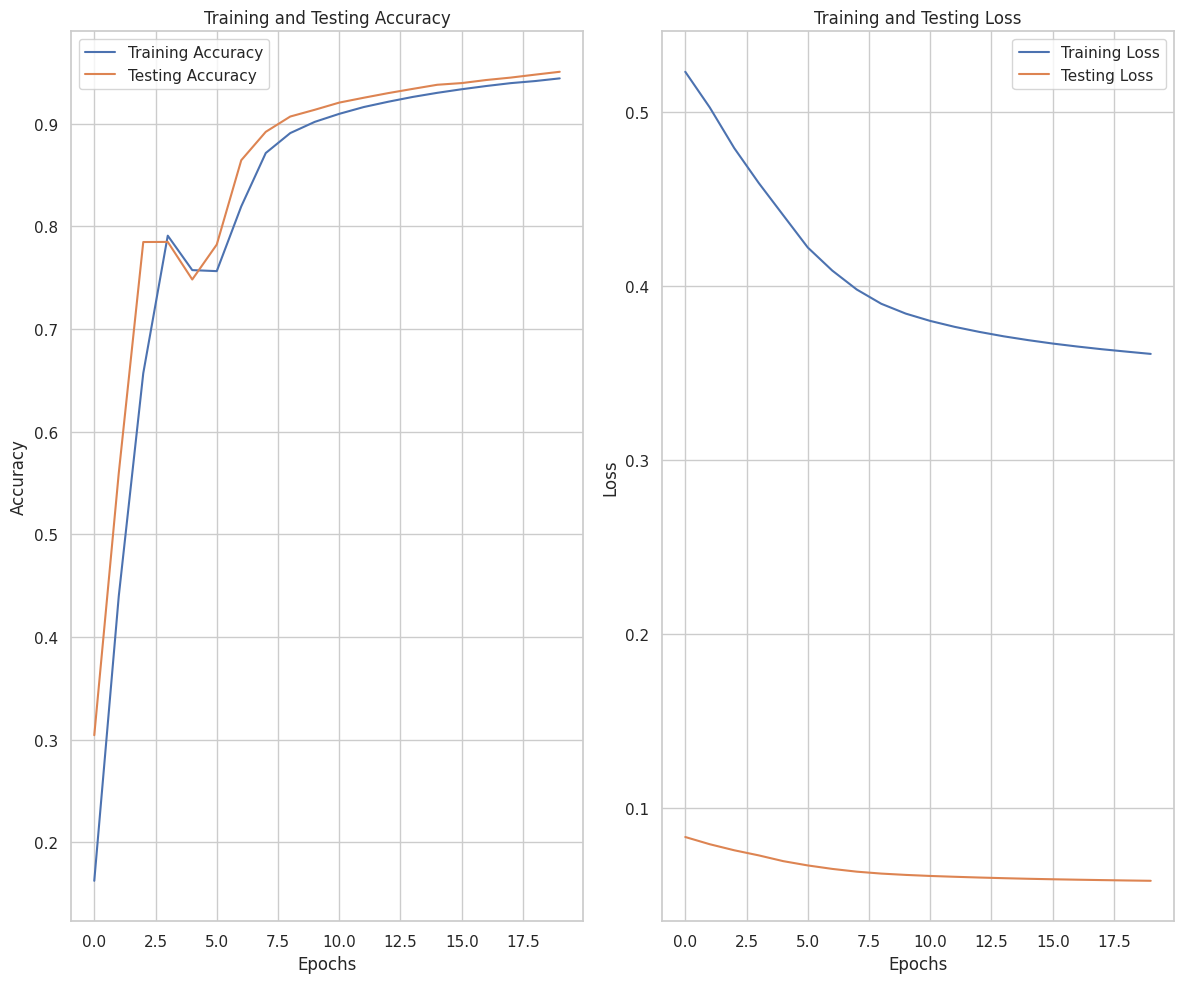

In [12]:
mnist_history = train_network(net = copy(mnist_net), batch_size = 512, epoches=20)

plot_training_history(mnist_history[1])

In [21]:
class AttackModel(nn.Module):
    def __init__(self):
        super(AttackModel, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

attack_model = AttackModel().to(device)
criterion_attack = nn.BCELoss()
optimizer_attack = torch.optim.Adam(attack_model.parameters(), lr=0.001)

# Fetching dataset
train_loader, test_loader = fetch_static_data( name = 'mnist', transform = transform, batch_size = 512, shuffle = True)

for epoch in range(5):  # Train for 5 epochs
    attack_model.train()
    for images, labels in train_loader:
        with torch.no_grad():
            model_output, _ = mnist_history[0](images.to(device))

        optimizer_attack.zero_grad()
        attack_input = model_output.detach().to(device)  # Use model predictions as input to attack model
        attack_output = attack_model(attack_input)
        target = torch.ones_like(attack_output)  # Label all training examples as "in" the training set
        loss_attack = criterion_attack(attack_output, target.to(device))
        loss_attack.backward()
        optimizer_attack.step()

# Evaluate the attack model
attack_model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    with torch.no_grad():
        model_output, _ = mnist_history[0](images.to(device))
    attack_input = model_output.detach().to(device)
    attack_output = attack_model(attack_input)
    predicted = torch.round(attack_output)
    total += labels.size(0)
    correct += (predicted == 1).sum().item()

print('Accuracy of the attack model on the test dataset: {:.2f}%'.format(100 * correct / total))

Accuracy of the attack model on the test dataset: 100.00%


In [37]:
attack_model.eval()
correct = 0
total = 0
predictions = []

for images, labels in test_loader:
    with torch.no_grad():
        model_output, _ = mnist_history[0](images.to(device))
    attack_input = model_output.detach().to(device)
    attack_output = attack_model(attack_input)
    predicted = torch.round(attack_output)
    predictions.append(predicted.cpu().detach().numpy())
    total += labels.size(0)
    correct += (predicted == 1).sum().item()

accuracy = correct / total
print('Accuracy of the attack model on the test dataset: {:.2f}%'.format(100 * accuracy))

Accuracy of the attack model on the test dataset: 100.00%


In [34]:
 print(test_loader.dataset.__doc__)

`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``
            and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.
        train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
            otherwise from ``t10k-images-idx3-ubyte``.
        download (bool, optional): If True, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    


In [ ]:
summary(mnist_net, (1, 28, 28))

In [ ]:
fashion_mnist_history = train_network(net = copy(mnist_net),  dataset_name = 'fashion-mnist', batch_size = 512, , epoches=20)

plot_metrics(fashion_mnist_history['train accuracy'], fashion_mnist_history['train loss'], fashion_mnist_history['test accuracy'], fashion_mnist_history['test loss'])

In [ ]:
summary(mnist_net, (1, 28, 28))

In [ ]:
cifar_10 = train_network(net = copy(mnist_net),  dataset_name = 'cifar-10', batch_size = 512, epoches=20)

plot_metrics(cifar_10['train accuracy'], cifar_10['train loss'], cifar_10['test accuracy'], cifar_10['test loss'])

In [ ]:
l.